In [6]:
#Import libraries and create dataframes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression

from prophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

df_0 = pd.read_csv("./data/data_set_2/clean_global_confirmed_cases.csv")
df_1 = pd.read_csv("./data/data_set_2/clean_global_deaths.csv")


Data Preparation

In [7]:
# Prepare teh data for visualisation by joining dataframes

world = pd.DataFrame({"Country":[],"Cases":[]})
world["Country"] = df_0.iloc[:,1:].columns
cases = []
for i in world["Country"]:
    cases.append(pd.to_numeric(df_0[i][1:]).sum())
world["Cases"]=cases

country_list=list(world["Country"].values)
idx = 0
for i in country_list:
    sayac = 0
    for j in i:
        if j==".":
            i = i[:sayac]
            country_list[idx]=i
        elif j=="(":
            i = i[:sayac-1]
            country_list[idx]=i
        else:
            sayac += 1
    idx += 1
world["Country"]=country_list
world = world.groupby("Country")["Cases"].sum().reset_index()
world.head()
continent=pd.read_csv("./data/data_set_1/continents.csv")
continent["name"]=continent["name"].str.upper()

Data Visialisation

In [8]:
# Initial visialisation of worldwwide spread of COVID-19 Cases
world["Cases Range"]=pd.cut(world["Cases"],[-150000,50000,200000,800000,1500000,15000000],labels=["U50K","50Kto200K","200Kto800K","800Kto1.5M","1.5M+"])
alpha =[]
for i in world["Country"].str.upper().values:
    if i == "BRUNEI":
        i="BRUNEI DARUSSALAM"
    elif  i=="US":
        i="UNITED STATES" 
    if len(continent[continent["name"]==i]["alpha-3"].values)==0:
        alpha.append(np.nan)
    else:
        alpha.append(continent[continent["name"]==i]["alpha-3"].values[0])
world["Alpha3"]=alpha

fig = px.choropleth(world.dropna(),
                   locations="Alpha3",
                   color="Cases Range",
                    projection="mercator",
                    color_discrete_sequence=["green","khaki","yellow","orange","red"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

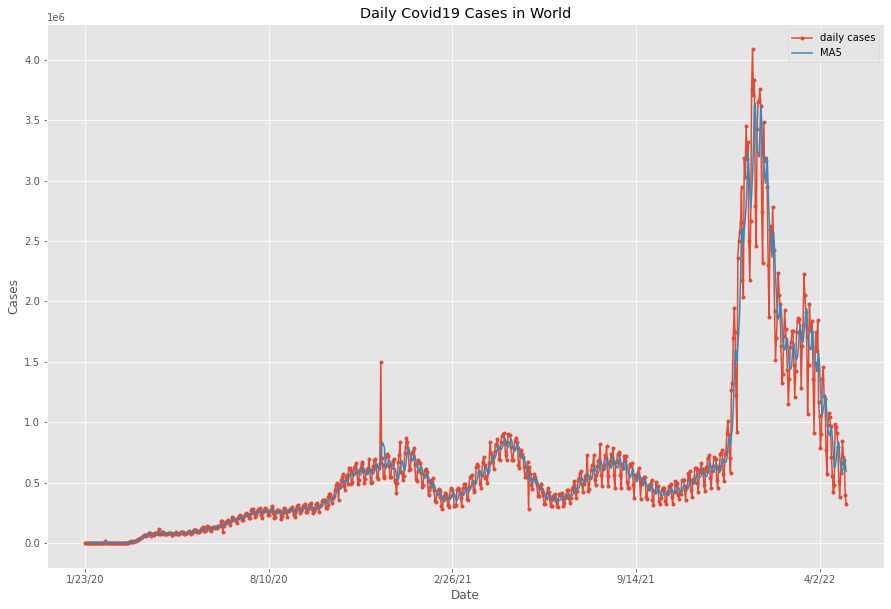

In [9]:
# Visualisation of global daily cases

count = []
for i in range(1,len(df_0)):
    count.append(sum(pd.to_numeric(df_0.iloc[i,1:].values)))

df = pd.DataFrame()
df["Date"] = df_0["Country/Region"][1:]
df["Cases"] = count
df=df.set_index("Date")

count = []
for i in range(1,len(df_1)):
    count.append(sum(pd.to_numeric(df_1.iloc[i,1:].values)))

df["Deaths"] = count

df.Cases.plot(title="Daily Covid19 Cases in World",marker=".",figsize=(15,10),label="daily cases")
df.Cases.rolling(window=5).mean().plot(figsize=(15,10),label="MA5")
plt.ylabel("Cases")
plt.legend()
plt.show()

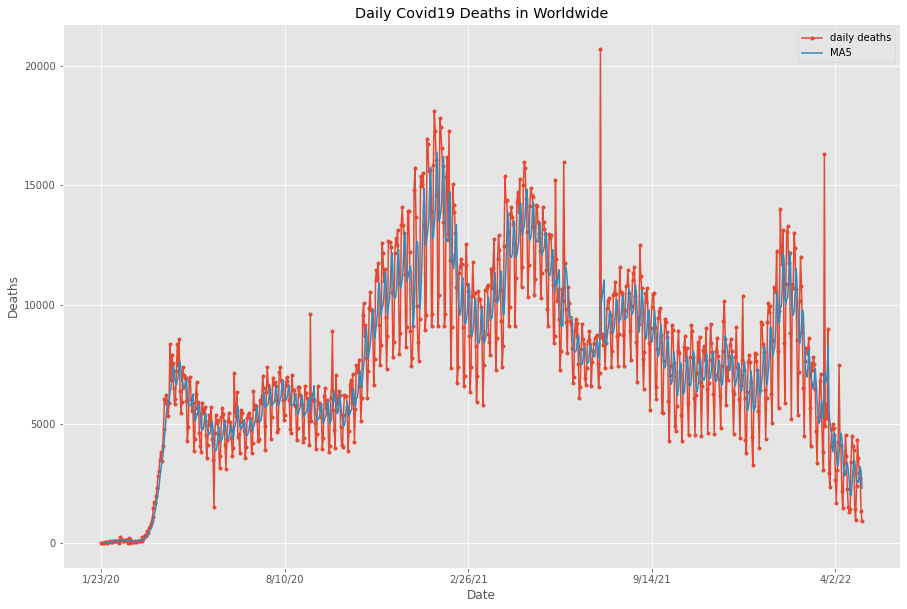

In [10]:
# Visualisation of global daily deaths

df.Deaths.plot(title="Daily Covid19 Deaths in Worldwide",marker=".",figsize=(15,10),label="daily deaths")
df.Deaths.rolling(window=5).mean().plot(figsize=(15,10),label="MA5")
plt.ylabel("Deaths")
plt.legend()
plt.show()

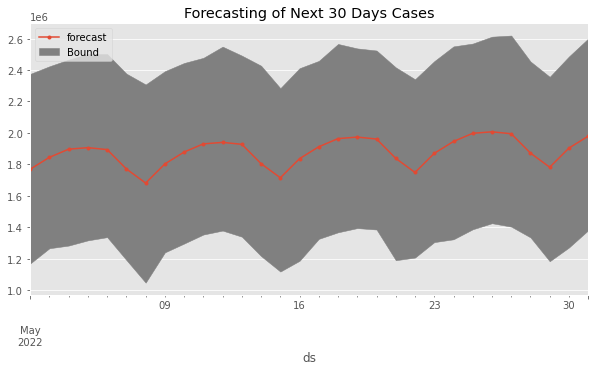

In [11]:
# Utilise histopircal data for prediction of cases for next 30 days

class prophet(object):
    def fit(self,data):
        
        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)
    
    def forecast(self,periods,freq):
        
        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)
        
    def plot(self,xlabel="Years",ylabel="Values"):
        
        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))
        
    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])
        
df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(df.index)
df_fb["y"]  = df.iloc[:,0].values

model = prophet()
model.fit(df_fb)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()

Create Linear Regression Model

In [30]:
# Read CSV File
data = pd.read_csv("./data/data_set_2/clean_global_confirmed_cases_total.csv")
data['Date'] = pd.to_datetime(data['Date'])
#Set the date as index
data = data.set_index('Date')

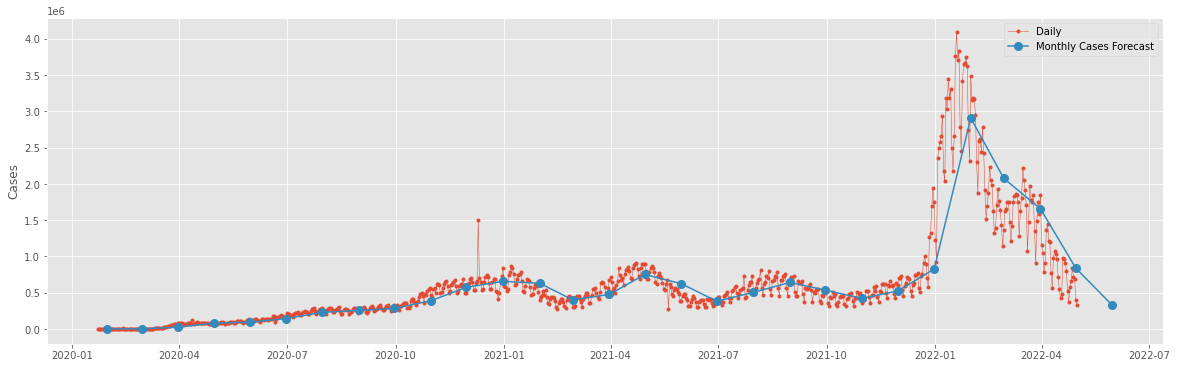

In [32]:
y = data['Total_Cases']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Cases Forecast')
ax.set_ylabel('Cases')
ax.legend();

In [33]:
# Convert date to interger number of days for Linear Regression

#data['Date'] = pd.to_datetime(data['Date'])    
#Set the date as index
#data = data.set_index('Date')

KeyError: 'Date'

In [34]:
# Perform linear regression

X=data['Date'].values.reshape(-1,1)
Y=data['Total_Cases'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X) # make predictions

KeyError: 'Date'

In [23]:
#df = ("./data/data_set_2/clean_global_confirmed_cases.csv")  # load data set
#X = df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = df.iloc[:, ].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X, Y)  # perform linear regression
#Y_pred = linear_regressor.predict(X)  # make predictions

NameError: name 'Y_pred' is not defined

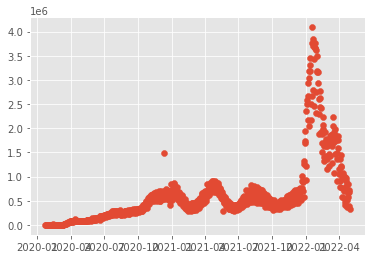

In [24]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()